# R Analysis: Immcantation analysis and figure generation
- Ruoyi Jiang
- October 24, 2018
- Run diversity, PCA/vgene, BASELINe, hotspot analysis, generate figures

# Before running
- Make sure that the processing notebook has been run to completion and there are no errors
- Download the supplemental table (Table S1) from Kelsoe et al. https://doi.org/10.1016/j.immuni.2016.02.010 . For accessibility, an excel version is provided with this repo however. 
- Clone https://bitbucket.org/kleinstein/pipeline_abseq/src/master/ using git. This is provided with the docker image. 

# Define locations
- Please modify this part of the notebook before running to specify the following file and directory locations as needed.

-- PLOT_DIR : This is the location where figures should be output. Will be output to the directory of this notebook if not changed. 

-- EXPERIMENT_DIR : This is the location of the change-o files. 

-- CHANGEO_PLOT_DIRS : This is the location of the thresholf files that were output while running change-o that corresponds to the pipeline described in the processing notebook. 

-- TAIL_NAME : This is the file extension for the change-o files you plan on using. Will default to the one that corresponds to the pipeline described in the processing notebook. 

-- KELSOE_TABLE : This is where the supplemental xlsx table downloaded from Kelsoe et al. is located. 

-- SATURN_DIR : This is where https://bitbucket.org/kleinstein/pipeline_abseq/src/master/ is cloned.

In [1]:
PLOT_DIR <- ""

EXPERIMENT_DIR <- "/data/changeo"
TAIL_NAME <- "-hc_parse-select_clone-pass_filter-pass_germ-pass_collapse-pass_filter-pass.tab"

CHANGEO_PLOT_DIRS <- "/data/changeo_plots"
KELSOE_TABLE <- "Table_Vgenes.xlsx"

SATURN_DIR <- "/git/pipeline_abseq"

# Load libraries

In [1]:
library(shazam)
library(alakazam)
library(tidyverse)
library(seqinr)
library(xlsx)
library(limma)
library(scales)

source(file.path(SATURN_DIR, "api/saturn/saturn.R"))

Loading required package: ggplot2
Loading required package: stringi

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following object is masked from ‘package:tidyr’:

    crossing

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [ ]:
# Set up status dictionary
STATUS_DICT <- c(
'PR8-1' = 'infected WT',
'PR8-2' = 'infected KO',
'PR8-3' = 'infected WT',
'PR8-4' = 'infected WT',
'PR8-5' = 'infected WT',
'PR8-6' = 'infected KO',
'PR8-7' = 'infected KO',
'PR8-8' = 'infected KO',
'PR8-9' = 'naive',#WT
'PR8-10' = 'naive',#WT
'PR8-11' = 'naive',#KO
'PR8-12' = 'naive'#KO
)

#Prepare color vector
STATUS_COLORS <- COLOR_PALETTE[[length(unique(STATUS_DICT))]]
names(STATUS_COLORS) <- unique(STATUS_DICT)

# Read in Change-O

In [ ]:
# Read in changeo
DF_DICT <- list()
samples <- list.files(file.path(EXPERIMENT_DIR))

for (sample in samples){
    if (sample %in% names(STATUS_DICT)){
        
        sample_df <- readChangeoDb(file.path(EXPERIMENT_DIR, sample, paste0(sample, 
            TAIL_NAME)))
        sample_df$SAMPLE <- sample
        sample_df$STATUS <- STATUS_DICT[sample]
        sample_df$CREGION <- translateStrings(sample_df$PRCONS, MOUSE_TRANS)
        sample_df <- sample_df %>%
            filter(!grepl(',', CREGION))

        #add to the dict
        DF_DICT[[sample]] <- sample_df
    }
}
DF <- bind_rows(DF_DICT)

# Implement a CDR3 filter
DF <- DF %>%
    rowwise() %>%
    mutate(JUNCTION_AA = translateDNA(JUNCTION, trim = F)) %>%
    mutate(CDR3_AA = translateDNA(JUNCTION, trim = T)) %>%
    filter(s2c(JUNCTION_AA)[1] == 'C' && (rev(s2c(JUNCTION_AA))[1] == 'W' || rev(s2c(JUNCTION_AA))[1] == 'F'))
    
# Only FUNCTIONAL VDJs
DF <- DF %>%
    filter(FUNCTIONAL == "TRUE")
    
# Compute mutations
DF <- observedMutations(DF, frequency=T, regionDefinition=NULL, nproc=3) %>%
    mutate(MU_FREQ=MU_FREQ_SEQ_R+MU_FREQ_SEQ_S)

In [13]:
#writeChangeoDb(DF, "db_flu.tab")

In [6]:
dim(DF)

[1] 11956    69

In [14]:
DF %>%
    group_by(SAMPLE, STATUS) %>%
    summarize(COUNT = n())

SAMPLE STATUS      COUNT
1  PR8-1  infected WT 1836 
2  PR8-10 naive        120 
3  PR8-11 naive        330 
4  PR8-12 naive        334 
5  PR8-2  infected KO 1109 
6  PR8-3  infected WT 1485 
7  PR8-4  infected WT 1183 
8  PR8-5  infected WT  972 
9  PR8-6  infected KO 1491 
10 PR8-7  infected KO 1935 
11 PR8-8  infected KO 1006 
12 PR8-9  naive        155

In [7]:
PLOT_ORDER <- c("naive", "infected WT", "infected KO")

In [8]:
fancy_status <- c("naive",
"italic(Bcl6)^{f/f}",
"italic(Bcl6)^{f/f} ~ italic(Foxp3)-Cre")

fancy_status_vector <- c("Naive"=expression(naive),
"infected WT"=expression(italic(Bcl6)^{f/f}),
"infected KO"=expression(italic(Bcl6)^{f/f} ~ italic(Foxp3)-Cre))

# Read Tables
- Output supplemental QC tables for NGS

In [10]:
ISO_CHOICES <- c("IgM", "IgG", "IgA", "IgD", "IgE")

read_table <- DF %>%
	filter(CREGION %in% ISO_CHOICES) %>%
	group_by(SAMPLE, STATUS, CREGION) %>%
	summarize(
			READS=sum(CONSCOUNT),
            UNIQ=n()
		) %>%
    ungroup() %>%
    complete(SAMPLE, CREGION, fill = list(READS=0, UNIQ=0, STATUS = "naive")) %>%
    rowwise() %>% data.frame()

clone_read_table <- DF %>%
    filter(CREGION %in% ISO_CHOICES) %>%
    group_by(SAMPLE, STATUS) %>%
    summarize(
            CLONES=length(unique(CLONE))
        ) 

In [14]:
clone_read_table$READS <-  
read_table[read_table$CREGION == "IgM", "READS"] + 
read_table[read_table$CREGION == "IgG", "READS"] + 
read_table[read_table$CREGION == "IgA", "READS"] +
read_table[read_table$CREGION == "IgD", "READS"] +
read_table[read_table$CREGION == "IgE", "READS"] 

clone_read_table$IGM_UNIQ <- read_table[read_table$CREGION == "IgM", "UNIQ"] 
clone_read_table$IGG_UNIQ <- read_table[read_table$CREGION == "IgG", "UNIQ"] 
clone_read_table$IGA_UNIQ <- read_table[read_table$CREGION == "IgA", "UNIQ"] 
clone_read_table$IGD_UNIQ <- read_table[read_table$CREGION == "IgD", "UNIQ"] 
clone_read_table$IGE_UNIQ <- read_table[read_table$CREGION == "IgE", "UNIQ"]

clone_counts <- clone_read_table$CLONES
clone_read_table$CLONES <- NULL
clone_read_table$CLONES <- clone_counts

clone_read_table %>%
    arrange(STATUS)

SAMPLE STATUS      READS  IGM_UNIQ IGG_UNIQ IGA_UNIQ IGD_UNIQ IGE_UNIQ
1  PR8-2  infected KO 422572 199       893       3        9      5       
2  PR8-6  infected KO 473038 283      1082     105       13      8       
3  PR8-7  infected KO 276615 271      1617      18       23      6       
4  PR8-8  infected KO 408283  82       905      10        6      3       
5  PR8-1  infected WT 891459 305      1438      50       40      3       
6  PR8-3  infected WT 402429 187      1138     149       10      1       
7  PR8-4  infected WT 457891 168       947      57        9      2       
8  PR8-5  infected WT 376249 161       758      41       10      2       
9  PR8-10 naive       370341  67         6       1       46      0       
10 PR8-11 naive       319007 171         6       1      152      0       
11 PR8-12 naive       402241 133        76       2      123      0       
12 PR8-9  naive       316609  82        15       1       57      0       
   CLONES
1  511   
2  709   
3  662   
4  499   
5  857   
6  599   
7  532   
8  416   
9   84   
10 261   
11 242   
12 106

In [15]:
clone_read_table %>%
    arrange(STATUS) %>% write.csv(file.path(PLOT_DIR, "reads.csv"))

# Plot and visualize DTN (distance to nearest)

In [ ]:
# Calculate DistToNearest using groupby and do
dtn_tab <- DF %>%
    group_by(SAMPLE) %>%
    do(distToNearest(., model="ham", first=FALSE, normalize="len", nproc=1)) %>%
    ungroup() %>%
    do(distToNearest(., model="ham", first=FALSE, normalize="len", cross="SAMPLE", nproc=1))

In [47]:
# Compute histogram of DTN distributions
dtn_sum <- dtn_tab %>%
    group_by(SAMPLE) %>%
    do(data.frame(DENSITY = hist(.$DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'DTN')

cross_sum <- dtn_tab %>%
    group_by(SAMPLE) %>%
    do(data.frame(DENSITY = -1 * hist(.$CROSS_DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'CROSS')

toplot_df <- bind_rows(dtn_sum, cross_sum)

In [44]:
thresh_list <- list()

for(sample in unique(dtn_tab$SAMPLE)){
    for(changeo_plot_dir in list.files(CHANGEO_PLOT_DIRS)){
        if(paste0(sample, "_threshold-values.tab") %in% list.files(changeo_plot_dir)){
            thresh_list[[sample]] <- read.table(file.path(changeo_plot_dir, paste0(sample, "_threshold-values.tab")), header = TRUE)
        }
    }
}

thresh_df <- bind_rows(thresh_list, .id = "SAMPLE") %>%
    group_by(SAMPLE) %>%
    summarize(THRESHOLD = mean(threshold, na.rm = TRUE))

In [29]:
plot_list <- list()

for(sample in unique(dtn_tab$SAMPLE)){
    
    THRESHOLD <- thresh_df %>%
        filter(SAMPLE == sample) %>%
        select(THRESHOLD)
    
    THRESHOLD <- as.numeric(THRESHOLD)

    plot_list[[sample]] <- ggplot(filter(toplot_df, SAMPLE == sample), 
             aes(x=BINS, y=DENSITY, fill=TYPE)) + 
    baseTheme() + 
    theme_bw() + 
    theme(legend.position="none") +
    xlab("Normalized hamming distance (Junction)") + 
    ylab("Density") +
    ggtitle(sample) +
    geom_bar(stat = "identity") +
    geom_vline(xintercept=THRESHOLD, color="firebrick", linetype=2) +
    scale_x_continuous(limits=c(0,0.75)) +
    scale_y_continuous(labels=abs) 
    
}

Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”

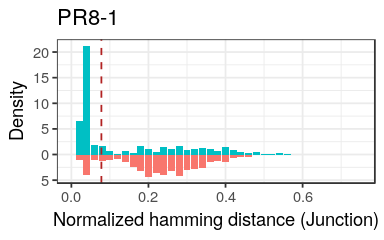

Warning message:
“Removed 26 rows containing missing values (position_stack).”

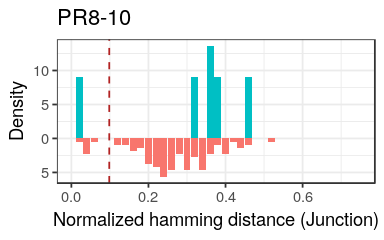

Warning message:
“Removed 26 rows containing missing values (position_stack).”

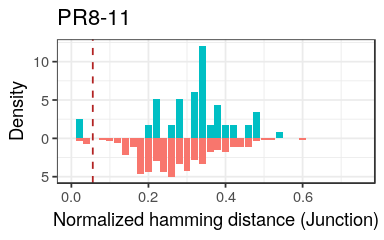

Warning message:
“Removed 26 rows containing missing values (position_stack).”

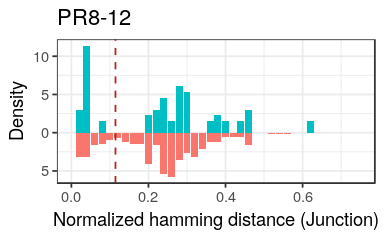

Warning message:
“Removed 26 rows containing missing values (position_stack).”

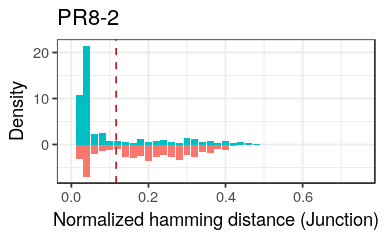

Warning message:
“Removed 26 rows containing missing values (position_stack).”

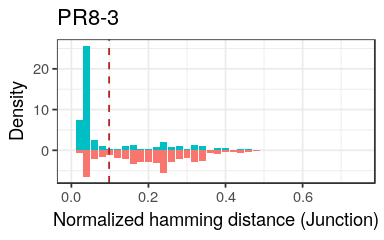

Warning message:
“Removed 26 rows containing missing values (position_stack).”

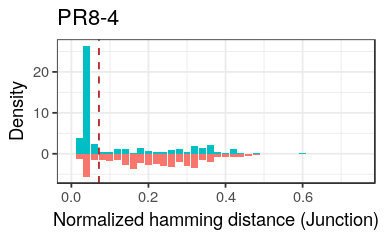

Warning message:
“Removed 26 rows containing missing values (position_stack).”

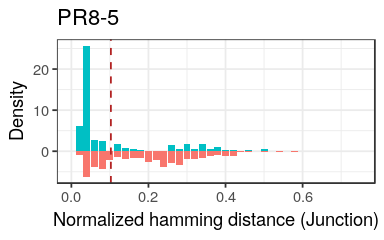

Warning message:
“Removed 26 rows containing missing values (position_stack).”

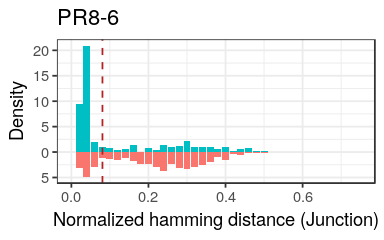

Warning message:
“Removed 26 rows containing missing values (position_stack).”

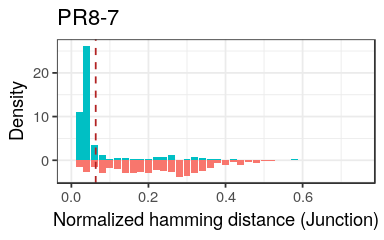

Warning message:
“Removed 26 rows containing missing values (position_stack).”

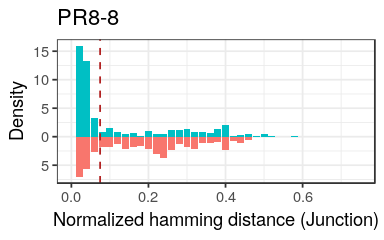

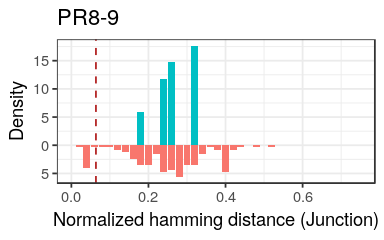

In [30]:
options(repr.plot.width=3.2, repr.plot.height=2)

for(sample in unique(dtn_tab$SAMPLE)){
    plot(plot_list[[sample]])
}

In [50]:
thresh_df <- thresh_df %>%
    mutate(STATUS = STATUS_DICT[SAMPLE]) %>%
    arrange(STATUS)

In [51]:
thresh_df %>% write.csv(file.path(PLOT_DIR, "changeo.csv"))

In [52]:
thresh_df %>%
    summarize(MEAN = mean(THRESHOLD), SD = sd(THRESHOLD))

MEAN       SD        
1 0.08472569 0.02055398

# Diversity
- Compute richness and simpson diversity of IgG

In [37]:
even_igg <- DF %>%
    filter(CREGION == "IgG") %>%
    rarefyDiversity("SAMPLE", clone="CLONE", min_q=0, max_q=2, step_q=2, ci=0.95, nboot=2000)

even_igg <- even_igg@diversity

Warning message:
“'rarefyDiversity' is deprecated.
Use 'alphaDiversity' instead.
See help("Deprecated")”

[1] 0 2


Warning message:
“'rarefyDiversity' is deprecated.
Use 'alphaDiversity' instead.
See help("Deprecated")”Warning message in estimateAbundance(data, group = group, clone = clone, copy = copy, :
“Not all groups passed threshold min_n=30. Excluded: PR8-10, PR8-11, PR8-9”

[1] 0 2


In [53]:
even_igg <- even_igg %>%
    rowwise() %>%
    mutate(STATUS = STATUS_DICT[SAMPLE]) %>%
    mutate(STATUS = factor(STATUS, levels = PLOT_ORDER)) %>%
    filter(STATUS != "naive")

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Ignoring unknown aesthetics: x”

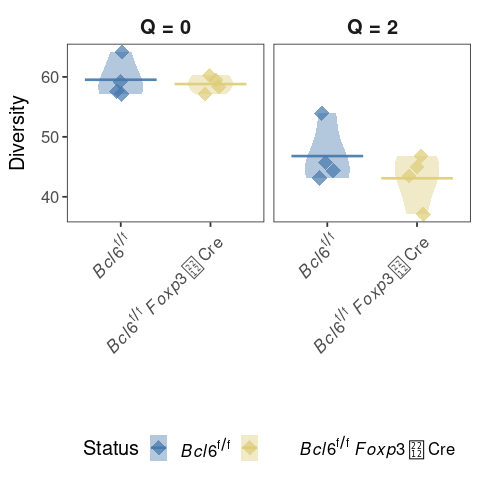

In [54]:
even_tab <- filter(even_igg, Q == 0 || Q == 2)

even_tab$Q[even_tab$Q == 0] <- "Q = 0"
even_tab$Q[even_tab$Q == 2] <- "Q = 2"

even_sum <- even_tab %>%
    group_by(STATUS,  Q) %>%
    dplyr::summarize(MEAN=mean(D, na.rm=T), SD=sd(D, na.rm=T))   

options(repr.plot.width=4, repr.plot.height=4)

p <- ggplot(even_tab, aes(x=STATUS, y=D)) + 
    baseTheme() + 
    #strip text removes the Q labels
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(breaks=seq(0, 300, 10)) +
    scale_x_discrete(labels = fancy_status_vector) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    #geom_boxplot(aes(fill=STATUS), position=position_dodge(0.8), width=0.7, size=0.25,
    #             color="grey10", outlier.colour=NA, alpha=0.4) +
    #geom_point(aes(color=STATUS), size=1.75, pch=18, alpha=0.9)
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    # geom_crossbar(data=even_sum, 
    #               aes(x=STATUS, y=MEAN, 
    #                   ymin=MEAN - SD, 
    #                   ymax=MEAN + SD, 
    #                   fill=STATUS),
    #               color="white", width=0.4, size=0.25, position=position_dodge(0.9), alpha=0.4) +
    geom_errorbarh(data=even_sum, 
                   aes(x=STATUS, y=MEAN, color=STATUS, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ Q)  
plot(p)

In [55]:
plotFigure(p, file.path(PLOT_DIR, "diversity_infected.pdf"), 4,4)

png 
  2

In [56]:
plotSvg(p, file.path(PLOT_DIR, "diversity_infected.svg"), 4,4)

png 
  2

# Isotype

In [57]:
DF <- DF %>%
    mutate(STATUS = STATUS_DICT[SAMPLE])

In [162]:
ISO_CHOICES <- c("IgM", "IgG", "IgA")

# Count isotypes
isotype_tab <- DF %>%
    group_by(SAMPLE, STATUS, CREGION) %>%
    summarize(ISO_COUNT=n()) %>%
    filter(CREGION %in% ISO_CHOICES) %>%
    mutate(CREGION=factor(CREGION, levels = ISO_CHOICES)) %>% 
    tidyr::complete(SAMPLE, STATUS, CREGION, fill=list(ISO_COUNT=0)) %>%
    group_by(SAMPLE, STATUS) %>%
    mutate(ISO_FREQ=ISO_COUNT/sum(ISO_COUNT, na.rm=T)) 

isotype_tab$CREGION <- factor(isotype_tab$CREGION, levels = ISO_CHOICES)
isotype_tab$STATUS <- factor(isotype_tab$STATUS, levels = PLOT_ORDER)

isotype_sum <- isotype_tab %>%
    group_by(STATUS, CREGION) %>%
    summarize(MEAN=mean(ISO_FREQ, na.rm=T), SD=sd(ISO_FREQ, na.rm=T))   

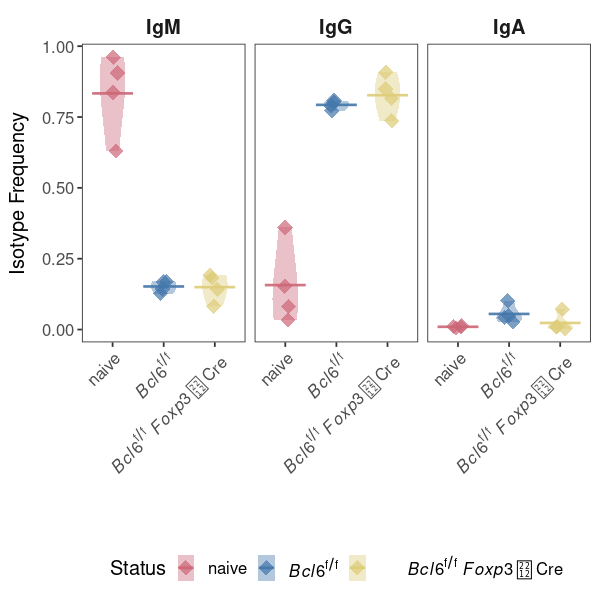

In [163]:
options(repr.plot.width=5, repr.plot.height=5)

p <- ggplot(isotype_tab, aes(x=STATUS, y=ISO_FREQ)) +
    baseTheme() + 
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("Isotype Frequency")) +
    scale_x_discrete(labels = fancy_status_vector) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=isotype_sum, 
                   aes(y=MEAN, color=STATUS, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ CREGION)
plot(p)

In [164]:
plotFigure(p, file.path(PLOT_DIR, "isotype.pdf"), 5,5)

png 
  2

In [165]:
plotSvg(p, file.path(PLOT_DIR, "isotype.svg"), 5,5)

png 
  2

# SHM

In [9]:
ISO_CHOICES <- c("IgM", "IgG", "IgA")

DF$CREGION <- factor(DF$CREGION, levels = ISO_CHOICES)

DF <- DF %>%
				filter(CREGION %in% ISO_CHOICES) %>%
                filter((grepl("infected", STATUS) & CREGION %in% c("IgM", "IgG"))|(grepl("naive", STATUS) & CREGION %in% c("IgM"))) %>%
                group_by(SAMPLE,  CREGION) %>%
                mutate(MU_FREQ=MU_FREQ_SEQ_R+MU_FREQ_SEQ_S)

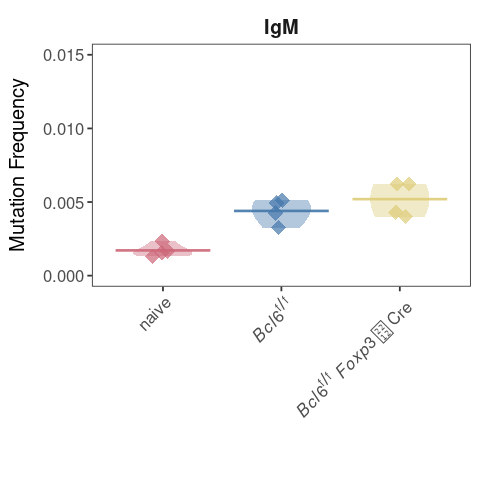

In [67]:
mut_avg <- DF %>%
                filter(CREGION == "IgM") %>%
               group_by(SAMPLE, STATUS, CREGION) %>%
               summarize(MEAN=mean(MU_FREQ), SD = sd(MU_FREQ)) %>% ungroup() %>%
                mutate(STATUS = factor(STATUS, levels=PLOT_ORDER))

mut_avg$CREGION <- factor(mut_avg$CREGION, levels = ISO_CHOICES)
mut_avg$TIME <- factor(mut_avg$STATUS, levels = PLOT_ORDER)

mut_sum <- mut_avg %>%
    group_by(STATUS, CREGION) %>%
    summarize(MEAN=mean(MEAN, na.rm=T), SD=sd(MEAN, na.rm=T)) 

options(repr.plot.width=4, repr.plot.height=4)

p <- ggplot(mut_avg, aes(x=STATUS, y=MEAN)) +
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle = 45, hjust = 1, vjust = 1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=8), legend.title=element_text(size=12)) +
    scale_y_continuous(limits = c(0, 0.015)) +    
    xlab("") +
    ylab(expression("Mutation Frequency")) +
    scale_x_discrete(labels = fancy_status_vector) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    geom_violin(aes(fill= STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=mut_sum, 
                   aes(y=MEAN, color=STATUS, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ CREGION)
plot(p)

In [68]:
plotFigure(p, file.path(PLOT_DIR, "shm_igm.pdf"), 4,4)

png 
  2

In [69]:
plotSvg(p, file.path(PLOT_DIR, "shm_igm.svg"), 4,4)

png 
  2

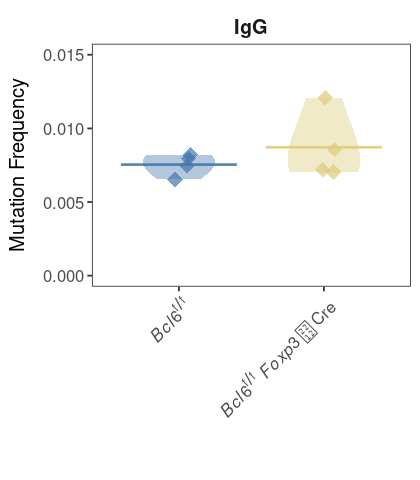

In [70]:
mut_avg <- DF %>%
                filter(CREGION == "IgG") %>%
               group_by(SAMPLE, STATUS, CREGION) %>%
               summarize(MEAN=mean(MU_FREQ), SD = sd(MU_FREQ)) %>% ungroup() %>%
                mutate(STATUS = factor(STATUS, levels=PLOT_ORDER))

mut_avg$CREGION <- factor(mut_avg$CREGION, levels = ISO_CHOICES)
mut_avg$TIME <- factor(mut_avg$STATUS, levels = PLOT_ORDER)

mut_sum <- mut_avg %>%
    group_by(STATUS, CREGION) %>%
    summarize(MEAN=mean(MEAN, na.rm=T), SD=sd(MEAN, na.rm=T)) 

options(repr.plot.width=3.5, repr.plot.height=4)

p <- ggplot(mut_avg, aes(x=STATUS, y=MEAN)) +
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle = 45, hjust = 1, vjust = 1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=8), legend.title=element_text(size=12)) +
    scale_y_continuous(limits = c(0, 0.015)) +  
    xlab("") +
    ylab(expression("Mutation Frequency")) +
    scale_x_discrete(labels = fancy_status_vector) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels = fancy_status_vector) +
    geom_violin(aes(fill= STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=mut_sum, 
                   aes(y=MEAN, color=STATUS, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ CREGION)
plot(p)

In [71]:
plotFigure(p, file.path(PLOT_DIR, "shm_igg.pdf"), 3.5,4)

png 
  2

In [72]:
plotSvg(p, file.path(PLOT_DIR, "shm_igg.svg"), 3.5,4)

png 
  2

# Altered selection R/S
- Process then plot BASELINe

In [ ]:
db_clones_igg <- DF %>%
    filter(CREGION == "IgG") %>%
    group_by(SAMPLE, STATUS, CLONE) %>%
    mutate(CLONE_SIZE=n()) %>%
    group_by(SAMPLE, STATUS) %>%
    mutate(CLONE_FREQ=CLONE_SIZE/n()) %>%
    filter(nchar(SEQUENCE_IMGT) == nchar(GERMLINE_IMGT_D_MASK)) %>%
    group_by(SAMPLE) %>%
    do(collapseClones(., regionDefinition=IMGT_V, expandedDb=F, nproc=1))

db_obs_igg <- observedMutations(data.frame(db_clones_igg), 
                                        sequenceColumn="CLONAL_SEQUENCE",
                                        regionDefinition=IMGT_V, 
                                        mutationDefinition=NULL, 
                                        nproc=1)                             
# Expected mutation frequencies
db_exp_igg <- expectedMutations(db_obs_igg,
                                    sequenceColumn="CLONAL_SEQUENCE",
                                    targetingModel=HH_S5F,
                                    regionDefinition=IMGT_V, 
                                    mutationDefinition=NULL, 
                                    nproc=1)
# Calculate baseline
baseline_igg <- calcBaseline(db_exp_igg, 
                         testStatistic="focused", 
                         regionDefinition=IMGT_V, 
                         nproc=1)

# Group baseline by status
baseline_grp_igg <- groupBaseline(baseline_igg, groupBy=c("STATUS"), nproc=1)

In [74]:
INFECTED_COLORS <- STATUS_COLORS[1:2]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Warning message:
“Removed 402 rows containing missing values (geom_path).”

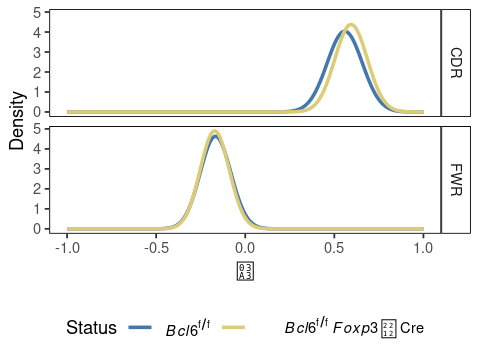

In [79]:
options(repr.plot.width=4, repr.plot.height=3)

p <- plotBaselineDensity(baseline_grp_igg, idColumn="STATUS", facetBy="region", sigmaLimits=c(-1, 1.0), colorValues = INFECTED_COLORS, silent=TRUE) +
#plotBaselineSummary(baseline_grp, idColumn="STATUS", facetBy="region", title = paste("Baseline Status", labels[1]))
theme(legend.position="bottom") +
scale_color_manual(values= INFECTED_COLORS, na.translate=FALSE, name="Status", labels=fancy_status_vector)
plot(p)

In [80]:
testBaseline(baseline_grp_igg, "STATUS")

REGION TEST                       PVALUE      FDR       
1 CDR    infected WT != naive       0.006623020 0.01986906
2 CDR    infected WT != infected KO 0.449432923 0.45751775
3 CDR    naive != infected KO       0.005319472 0.01986906
4 FWR    infected WT != naive       0.457517753 0.45751775
5 FWR    infected WT != infected KO 0.266907603 0.45751775
6 FWR    naive != infected KO       0.342564718 0.45751775

In [81]:
plotFigure(p, file.path(PLOT_DIR, "baseline_igg.pdf"), 4,3)

Warning message:
“Removed 402 rows containing missing values (geom_path).”

png 
  2

In [82]:
plotSvg(p, file.path(PLOT_DIR, "baseline_igg.svg"), 4,3)

Warning message:
“Removed 402 rows containing missing values (geom_path).”

png 
  2

# Hot/Cold Spot Analysis

In [ ]:
# calculate motif frequencies
model_list <- list()
for(sample in names(STATUS_DICT)){
    cat(sample)
    model_list[[sample]] <- createTargetingModel(filter(db_clones, SAMPLE==sample), model="RS", 
                            sequenceColumn="CLONAL_SEQUENCE", 
                            germlineColumn="CLONAL_GERMLINE") 
}

# extract out mutabilities as a list
model_mutability_list <- list()
for(sample in names(STATUS_DICT)){
    model_mutability_list[[sample]] <- data.frame(MUTABILITY = model_list[[sample]]@mutability) %>%
        mutate(WORD = names(model_list[[sample]]@mutability))
}

# convert list to table
model_mutability_df <- bind_rows(model_mutability_list, .id="SAMPLE") %>%
    filter(!grepl('N', WORD)) %>%
    spread(SAMPLE, MUTABILITY) %>%
    rowwise() %>%
    mutate(MOTIF = word2motif(WORD)) %>%
    select(c("MOTIF","WORD", "PR8-1", "PR8-2", "PR8-3", "PR8-4", "PR8-6", "PR8-7", "PR8-8")) %>%
    gather(SAMPLE, MUTABILITY, -MOTIF, -WORD) %>%
    rowwise() %>%
    mutate(STATUS = factor(STATUS_DICT[SAMPLE], levels=PLOT_ORDER))

# summarize the mutabilities for each SAMPLE
model_mutability_motif_df <- model_mutability_df %>%
    group_by(SAMPLE, STATUS, MOTIF) %>%
    summarize(MEAN = mean(MUTABILITY), SD = sd(MUTABILITY))

# summarize the mutabilities for each STATUS
model_mutability_motif_sum <- model_mutability_motif_df %>%
    group_by(STATUS, MOTIF) %>%
    summarize(MEAN = mean(MEAN), SD = sd(MEAN))

In [238]:
model_mutability_motif_df$STATUS <- factor(model_mutability_motif_df$STATUS, levels = PLOT_ORDER)

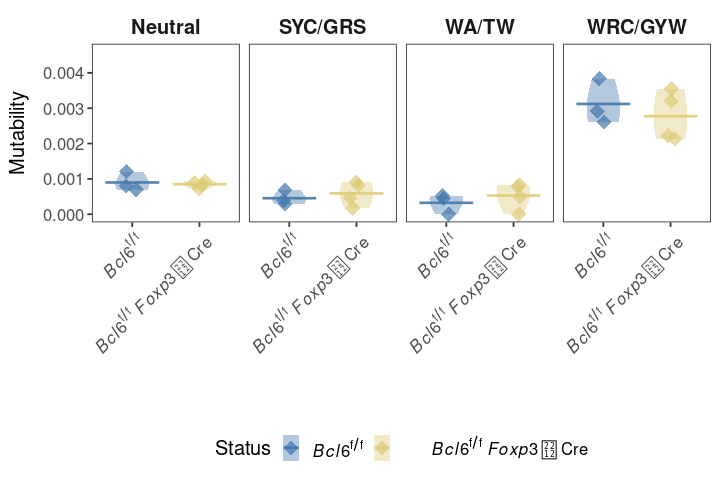

In [239]:
options(repr.plot.width=6, repr.plot.height=4)

min_y <- min(model_mutability_motif_df$MEAN) * 0.8
max_y <- max(model_mutability_motif_df$MEAN) * 1.2

p <- ggplot(model_mutability_motif_df, aes(x=STATUS, y=MEAN)) +
    baseTheme() + 
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("Mutability")) +
    scale_x_discrete(labels=fancy_status_vector) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels=fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels=fancy_status_vector) +
    scale_y_continuous(limits = c(min_y, max_y)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=model_mutability_motif_sum, 
                   aes(y=MEAN, color=STATUS, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    facet_grid(. ~ MOTIF)
plot(p)

In [89]:
plotFigure(p, file.path(PLOT_DIR, "shm_motif.pdf"), 6,4)

png 
  2

In [90]:
plotSvg(p, file.path(PLOT_DIR, "shm_motif.svg"), 6,4)

png 
  2

# Gene usage

In [24]:
#will be implemented within countGenes in latest function
countAbsent <- function(df, groups){
    #choose separator that is highly unlikely to be in names in GROUP
    char_separator = '@'
    
    count_columns <- c('SEQ_COUNT', 'SEQ_FREQ')
    out_df <- df %>%
        unite(temp_key, groups, sep = char_separator) %>%
        unite(temp_value, count_columns, sep = char_separator) %>%
        spread(temp_key, temp_value, fill = paste(rep(0, 2), collapse=char_separator)) %>%
        gather(temp_key, temp_value, -GENE) %>%
        separate(temp_key, groups, sep = char_separator) %>%
        separate(temp_value, count_columns, sep = char_separator) %>%
        mutate_at(vars(count_columns), funs(as.numeric))
    
    return(out_df)
}

In [28]:
grouping <- c('SAMPLE', 'STATUS')

vgene_tab <- countGenes(DF, gene= 'V_CALL', groups=grouping, mode = 'gene') %>%
    countAbsent(groups=grouping) %>%
    mutate(STATUS = factor(STATUS, levels = PLOT_ORDER))

In [29]:
grouping <- c('SAMPLE', 'STATUS', 'CREGION')

vgene_iso_tab <- countGenes(DF, gene= 'V_CALL', groups=grouping, mode = 'gene') %>%
    countAbsent(groups=grouping) %>%
    mutate(STATUS = factor(STATUS, levels = PLOT_ORDER))

# Extract out V gene usage of HA+ and PA+ B cells from Kelsoe et al.

In [100]:
kelsoe_df <- read.xlsx(KELSOE_TABLE, sheetIndex = 1) %>%
    mutate(GENE = paste0("IGHV", GENE)) %>%
    gather(key = 'SAMPLE', value = 'SEQ_FREQ', -GENE)

In [101]:
df_pca_kelsoe <- vgene_tab %>%
    select(GENE, SEQ_FREQ, SAMPLE) %>%
    bind_rows(kelsoe_df) %>%
    spread(key = GENE, value= SEQ_FREQ) %>%
    select_if(~ !any(is.na(.))) %>%
    column_to_rownames(var="SAMPLE") %>%
    t() %>%
    na.omit()

In [102]:
df_pca_kelsoe_diff <- data.frame(df_pca_kelsoe) %>%
    rowwise() %>%
    mutate(
            GC_d8_HA_DIFF = GC_d8_HA_TRUE - GC_d8_HA_FALSE,
            GC_d16_HA_DIFF = GC_d16_HA_TRUE - GC_d16_HA_FALSE,
            GC_d8_PA_DIFF = GC_d8_PA_TRUE - GC_d8_PA_FALSE,
            GC_d16_PA_DIFF = GC_d16_PA_TRUE - GC_d16_PA_FALSE
          ) %>%
    select(contains("PR"), contains("GC")) %>%
    as.matrix()

rownames(df_pca_kelsoe_diff) <- rownames(df_pca_kelsoe)

# Total repertoire V gene PCA

In [32]:
df_pca <- vgene_tab %>%
    select(GENE, SAMPLE, STATUS, SEQ_FREQ) %>%
    spread(key = GENE, value= SEQ_FREQ)

df_out <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$x, STATUS = df_pca$STATUS)

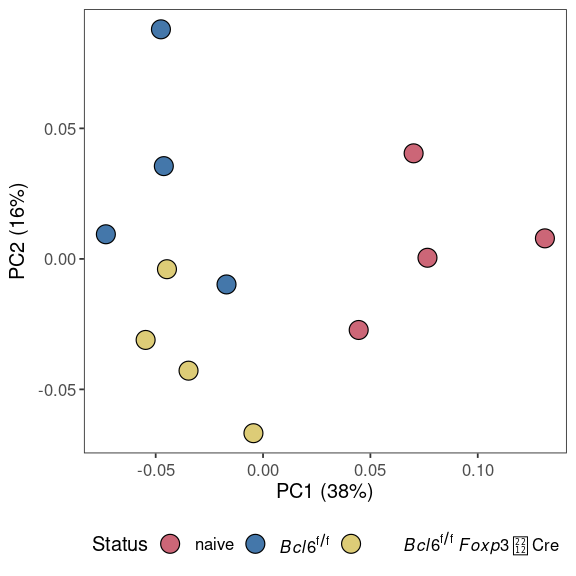

In [104]:
options(repr.plot.width=4.8, repr.plot.height=4.8)

p <- ggplot(df_out,aes(x=PC1,y=PC2,fill=STATUS))+
    geom_point(colour="black",pch=21, size=5) +
    baseTheme() + 
    #strip text removes the Q labels
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("PC1 (38%)") +
    ylab(expression("PC2 (16%)")) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels=fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels=fancy_status_vector)
plot(p)

In [105]:
vgene_tab %>% head()

GENE     SAMPLE STATUS      SEQ_COUNT SEQ_FREQ    
1 IGHV1-11 PR8-1  infected WT  1        0.0005446623
2 IGHV1-12 PR8-1  infected WT 12        0.0065359477
3 IGHV1-14 PR8-1  infected WT  0        0.0000000000
4 IGHV1-15 PR8-1  infected WT 24        0.0130718954
5 IGHV1-18 PR8-1  infected WT 12        0.0065359477
6 IGHV1-19 PR8-1  infected WT 15        0.0081699346

In [106]:
plotFigure(p, file.path(PLOT_DIR, "pca.pdf"), 4.8, 4.8)

png 
  2

In [107]:
plotSvg(p, file.path(PLOT_DIR, "pca.svg"), 4.8, 4.8)

png 
  2

In [101]:
data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC2) %>%
    head()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

GENE     PC1         PC2        PC3         PC4         PC5        
1 IGHV10-3  0.32320309 -0.3411492 -0.27817711  0.59767497 -0.18630968
2 IGHV9-3  -0.64122088 -0.3018347 -0.08801886  0.18401508 -0.05182449
3 IGHV14-2 -0.14382107 -0.2404664  0.14042040  0.16255432  0.32152934
4 IGHV8-8  -0.04751893 -0.1976101  0.17125628 -0.17880732  0.10374709
5 IGHV1-69 -0.06510128 -0.1631710 -0.25123330 -0.32924560 -0.38025240
6 IGHV3-6  -0.01132208 -0.1432473  0.06076493 -0.04806973  0.06326674
  PC6          PC7         PC8         PC9         PC10        PC11        
1  0.008034070  0.08542866 -0.27046657 -0.11515228 -0.04121236  0.128495721
2 -0.210765324 -0.12916486  0.08324812 -0.03432477  0.15743760 -0.012702276
3 -0.004962723 -0.04707050 -0.27757746  0.23032534 -0.07654848 -0.163149224
4  0.412380837 -0.20129056 -0.11383615 -0.01758335  0.13340037  0.004135779
5  0.331212475  0.05719022  0.09748113  0.11448179  0.09523155  0.097478471
6  0.203104613  0.15576657  0.01975323 -0.02084613 -0.36885015 -0.140775730
  PC12        
1 -0.034538970
2 -0.046494383
3  0.015215304
4 -0.056279636
5  0.007457869
6  0.027364530

In [102]:
pc_gene_down <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC2) %>%
    head() %>%
    select(GENE) %>%
    unlist()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

In [103]:
data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC2) %>%
    tail()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

GENE     PC1         PC2       PC3         PC4         PC5        
1 IGHV1-66 -0.05038388 0.1135669 -0.02902090  0.01699422  0.03199198
2 IGHV1-81 -0.00693823 0.1861607 -0.02216075  0.03884587 -0.09547931
3 IGHV1-78 -0.08391318 0.1887170 -0.22368806  0.11149208  0.18119200
4 IGHV8-12 -0.14297627 0.3162519 -0.26059193 -0.08639446  0.26606419
5 IGHV5-17 -0.11145604 0.3345953  0.11656935 -0.14934637 -0.18622043
6 IGHV9-4  -0.12783055 0.4938291 -0.03150358  0.39988921  0.02567292
  PC6         PC7         PC8         PC9         PC10        PC11       
1  0.01511883  0.05944913 -0.16471824  0.03059820 -0.06597246 -0.09805954
2 -0.14264766  0.02765488 -0.01491178 -0.21799258  0.19347128 -0.19388088
3  0.13988233  0.09749854 -0.11726709 -0.06144436  0.14127917 -0.05602665
4  0.05880313  0.10611750 -0.27992853  0.02736310  0.05669677 -0.10333624
5 -0.19054147  0.10849911 -0.27869345  0.13383376 -0.09274822  0.06137295
6  0.29778978 -0.12028701  0.18903848 -0.01406342 -0.06777806  0.05807835
  PC12       
1 -0.09112533
2 -0.15697360
3 -0.02712557
4 -0.02123569
5  0.07306067
6  0.04448850

In [33]:
pc_gene_up <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC2) %>%
    tail() %>%
    select(GENE) %>%
    unlist()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

In [34]:
summary(prcomp(select(df_pca, -SAMPLE, -STATUS)))

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.06485 0.04145 0.03587 0.02945 0.02582 0.02352 0.02241
Proportion of Variance 0.38614 0.15773 0.11815 0.07961 0.06123 0.05080 0.04612
Cumulative Proportion  0.38614 0.54387 0.66202 0.74163 0.80286 0.85366 0.89978
                           PC8     PC9    PC10    PC11      PC12
Standard deviation     0.01997 0.01678 0.01496 0.01368 8.291e-18
Proportion of Variance 0.03662 0.02585 0.02056 0.01719 0.000e+00
Cumulative Proportion  0.93640 0.96225 0.98281 1.00000 1.000e+00

# Correlation of PCA w Kelsoe Data

In [108]:
pc_df <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE")

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

In [107]:
kelsoe_diff_df <- data.frame(df_pca_kelsoe_diff) %>%
    add_rownames("GENE") %>%
    inner_join(pc_df , by = "GENE") %>%
    filter(GC_d8_HA_DIFF != 0, GC_d16_HA_DIFF != 0)

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

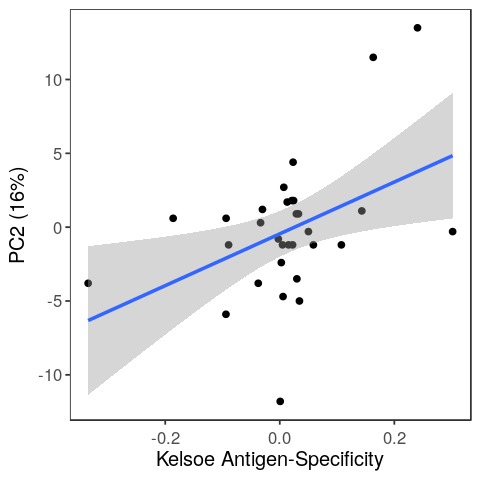

In [467]:
p <- ggplot(kelsoe_diff_df, aes(x=-PC2, y=GC_d16_HA_DIFF)) +
    geom_point() + 
    baseTheme() + 
    geom_smooth(method = "lm") +
    #strip text removes the Q labels
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Kelsoe Antigen-Specificity") +
    ylab(expression("PC2 (16%)"))
plot(p)

In [464]:
plotFigure(p, file.path(PLOT_DIR, "d16_ha_corr.pdf"), 4, 4)

png 
  2

In [465]:
plotSvg(p, file.path(PLOT_DIR, "d16_ha_corr.svg"), 4, 4)

png 
  2

In [408]:
cor.test(-kelsoe_diff_df$PC2, kelsoe_diff_df$GC_d16_HA_DIFF)


	Pearson's product-moment correlation

data:  -kelsoe_diff_df$PC2 and kelsoe_diff_df$GC_d16_HA_DIFF
t = 2.6075, df = 29, p-value = 0.01426
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09634004 0.68444889
sample estimates:
      cor 
0.4358031 


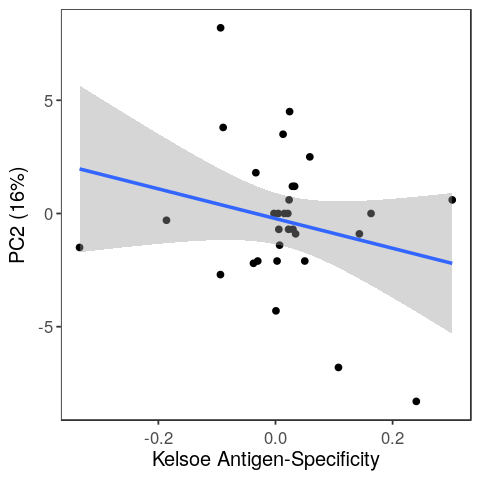

In [468]:
p <- ggplot(kelsoe_diff_df, aes(x=-PC2, y=GC_d16_PA_DIFF)) +
    geom_point() + 
    baseTheme() + 
    geom_smooth(method = "lm") +
    #strip text removes the Q labels
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Kelsoe Antigen-Specificity") +
    ylab(expression("PC2 (16%)"))
plot(p)

In [469]:
plotFigure(p, file.path(PLOT_DIR, "d16_pa_corr.pdf"), 4, 4)

png 
  2

In [470]:
plotSvg(p, file.path(PLOT_DIR, "d16_pa_corr.svg"), 4, 4)

png 
  2

In [412]:
cor.test(-kelsoe_diff_df$PC2, kelsoe_diff_df$GC_d16_PA_DIFF)


	Pearson's product-moment correlation

data:  -kelsoe_diff_df$PC2 and kelsoe_diff_df$GC_d16_PA_DIFF
t = -1.3328, df = 29, p-value = 0.193
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5479430  0.1247072
sample estimates:
       cor 
-0.2402492 


# Total Heatmap and PCA vectors

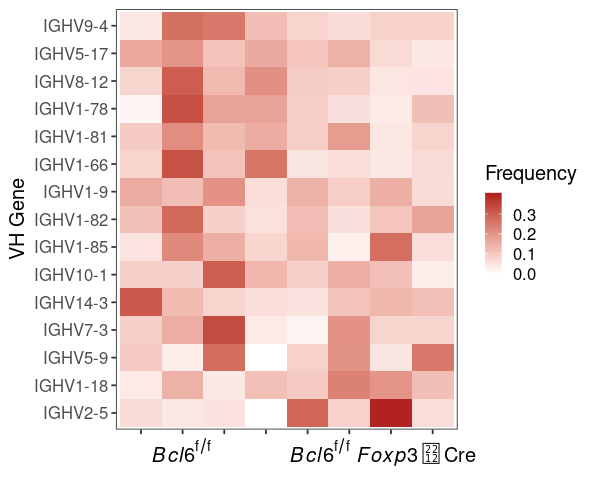

In [123]:
toplot_vgene_tab <- vgene_tab %>%
    filter(GENE %in% pc_gene_up) %>%
    filter(!(SAMPLE %in% naive_samples)) %>%
    mutate(SAMPLE = sample_order[SAMPLE]) %>%
    mutate(GENE = factor(GENE, levels = pc2_genes), SAMPLE=factor(SAMPLE, levels= plot_order)) %>%
    group_by(GENE) %>%
    mutate(SEQ_FREQ = SEQ_FREQ/sum(SEQ_FREQ))

options(repr.plot.width=5, repr.plot.height=4)

p <- ggplot(toplot_vgene_tab, aes(y=GENE, x= SAMPLE)) + 
geom_tile(aes(fill = SEQ_FREQ)) + 
baseTheme() +
xlab(expression(~~~~~~~~~italic(Bcl6)^{f/f} ~~~~~~~~~~~~~ italic(Bcl6)^{f/f} ~ italic(Foxp3)-Cre)) +
ylab("VH Gene") +
theme(legend.position="right", axis.title.x=element_text(size=12), axis.text.x=element_blank(), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
scale_fill_gradient(low = "white", high = "firebrick", name = "Frequency")

plot(p)

In [124]:
plotFigure(p, file.path(PLOT_DIR, "heat_up.pdf"), 5, 4)

png 
  2

In [125]:
plotSvg(p, file.path(PLOT_DIR, "heat_up.svg"), 5, 4)

png 
  2

# IgG PCA

In [138]:
df_pca <- vgene_iso_tab %>%
    filter(CREGION == "IgG", grepl("infected", STATUS)) %>%
    select(GENE, SAMPLE, STATUS, SEQ_FREQ) %>%
    spread(key = GENE, value= SEQ_FREQ)

df_out <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$x, STATUS = df_pca$STATUS)

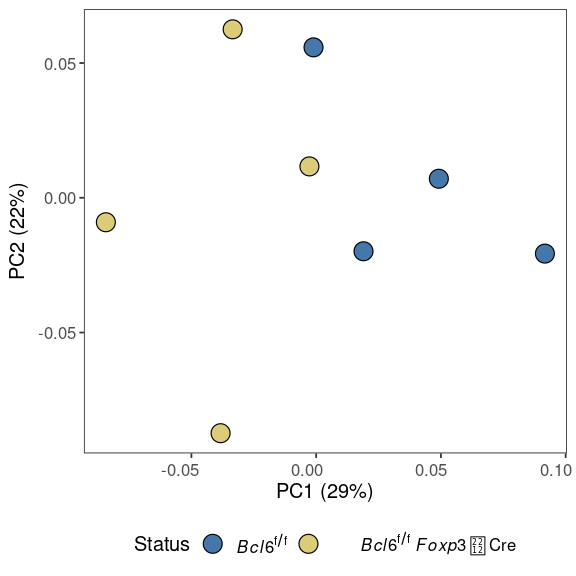

In [139]:
options(repr.plot.width=4.8, repr.plot.height=4.8)

p <- ggplot(df_out,aes(x=PC1,y=PC2,fill=STATUS))+
    geom_point(pch=21, colour="black", size=5) +
    baseTheme() + 
    #strip text removes the Q labels
    theme(legend.position="bottom", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10, hjust= 0.8), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("PC1 (29%)") +
    ylab(expression("PC2 (22%)")) +
    scale_fill_manual(values=STATUS_COLORS, name="Status", labels=fancy_status_vector) +
    scale_color_manual(values=STATUS_COLORS, name="Status", labels=fancy_status_vector)

plot(p)

In [140]:
plotFigure(p, file.path(PLOT_DIR, "pca_igg.pdf"), 4.8, 4.8)

png 
  2

In [141]:
plotSvg(p, file.path(PLOT_DIR, "pca_igg.svg"), 4.8, 4.8)

png 
  2

In [151]:
data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC1) %>%
    head()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

GENE     PC1        PC2        PC3         PC4          PC5        
1 IGHV10-3 -0.5120358 -0.1983452  0.60090501  0.206976270 -0.13046739
2 IGHV9-3  -0.2027820 -0.2594105 -0.26385987  0.130099505  0.26253298
3 IGHV14-2 -0.1719394  0.2569551  0.10658899  0.035786076 -0.09662007
4 IGHV1-69 -0.1582163 -0.4332929 -0.27664412 -0.295189473 -0.12189625
5 IGHV8-8  -0.1565830  0.2065672 -0.16895405 -0.455134420 -0.26881916
6 IGHV1-55 -0.1042232  0.1494036 -0.01528848  0.002698319 -0.12364466
  PC6         PC7          PC8        
1 -0.07174750 -0.211400022  0.13658104
2 -0.30871858  0.168850975  0.35458797
3 -0.30878771  0.392925964 -0.29011630
4  0.29307844  0.066142702 -0.02389488
5 -0.18624872 -0.004460859  0.10150907
6  0.04995822 -0.030105726 -0.05129101

In [152]:
data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC1) %>%
    tail()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

GENE     PC1       PC2           PC3           PC4         PC5        
1 IGHV1-66 0.1348733 -0.0540149520  0.0388238027  0.06073948 -0.10860704
2 IGHV1-81 0.1942545 -0.0548651464 -0.0009589856  0.16767090  0.01554614
3 IGHV1-78 0.2355006 -0.1514401862  0.2228797861 -0.07529721 -0.14260259
4 IGHV8-12 0.3171059 -0.1748963203  0.0440762366  0.09302438 -0.34498183
5 IGHV5-17 0.3992528 -0.0006677793 -0.1547513508  0.26693258 -0.22547912
6 IGHV9-4  0.4164342 -0.1093221011  0.3836089860 -0.32812316  0.27947615
  PC6         PC7         PC8         
1 -0.14228655  0.09219300  0.064767982
2 -0.06886224 -0.09602074  0.128806628
3 -0.12101497 -0.05968949 -0.007804821
4 -0.29763116  0.16533403  0.151535667
5  0.08454356 -0.07740700 -0.010245573
6 -0.09380083  0.04861019 -0.097001054

In [153]:
summary(prcomp(select(df_pca, -SAMPLE, -STATUS)))

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.05462 0.04742 0.04222 0.03537 0.02998 0.02657 0.02435
Proportion of Variance 0.28512 0.21492 0.17033 0.11957 0.08591 0.06747 0.05668
Cumulative Proportion  0.28512 0.50004 0.67038 0.78994 0.87585 0.94332 1.00000
                             PC8
Standard deviation     7.843e-18
Proportion of Variance 0.000e+00
Cumulative Proportion  1.000e+00

In [142]:
pc1_genes <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC1) %>%
    select(GENE) %>%
    unlist()

gene_list_size <- 15

pc_gene_up <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC1) %>%
    tail(gene_list_size) %>%
    select(GENE) %>%
    unlist()

pc_gene_down <- data.frame(prcomp(select(df_pca, -SAMPLE, -STATUS))$rotation) %>%
    add_rownames("GENE") %>%
    arrange(PC1) %>%
    head(gene_list_size) %>%
    select(GENE) %>%
    unlist()

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”

# IgG Heatmap and PCA vectors

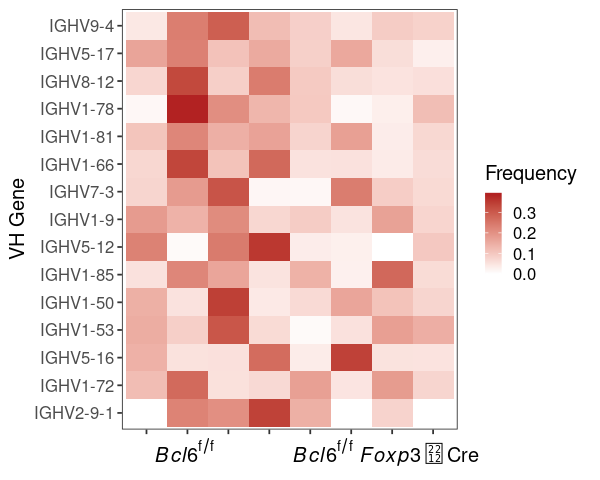

In [143]:
toplot_vgene_tab <- vgene_iso_tab %>%
    filter(CREGION == "IgG") %>%
    filter(GENE %in% pc_gene_up) %>%
    filter(!(SAMPLE %in% naive_samples)) %>%
    mutate(SAMPLE = sample_order[SAMPLE]) %>%
    mutate(GENE = factor(GENE, levels = pc1_genes), SAMPLE=factor(SAMPLE, levels= plot_order)) %>%
    group_by(GENE) %>%
    mutate(SEQ_FREQ = SEQ_FREQ/sum(SEQ_FREQ))

options(repr.plot.width=5, repr.plot.height=4)

p <- ggplot(toplot_vgene_tab, aes(y=GENE, x= SAMPLE)) + 
geom_tile(aes(fill = SEQ_FREQ)) + 
baseTheme() +
xlab(expression(~~~~~~~~~italic(Bcl6)^{f/f} ~~~~~~~~~~~~~ italic(Bcl6)^{f/f} ~ italic(Foxp3)-Cre)) +
ylab("VH Gene") +
theme(legend.position="right", axis.title.x=element_text(size=12), axis.text.x=element_blank(), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
scale_fill_gradient(low = "white", high = "firebrick", name = "Frequency")

plot(p)

In [144]:
plotFigure(p, file.path(PLOT_DIR, "heat_igg_up.pdf"), 5, 4)

png 
  2

In [145]:
plotSvg(p, file.path(PLOT_DIR, "heat_igg_up.svg"), 5, 4)

png 
  2

# Plot individual V genes among IgG

[1] "IGHV1-66"
            infected WT
infected KO  0.02857143
[1] "IGHV1-81"
            infected WT
infected KO         0.2
[1] "IGHV1-78"
            infected WT
infected KO         0.2
[1] "IGHV8-12"
            infected WT
infected KO   0.1142857
[1] "IGHV5-17"
            infected WT
infected KO   0.1142857
[1] "IGHV9-4"
            infected WT
infected KO   0.3428571


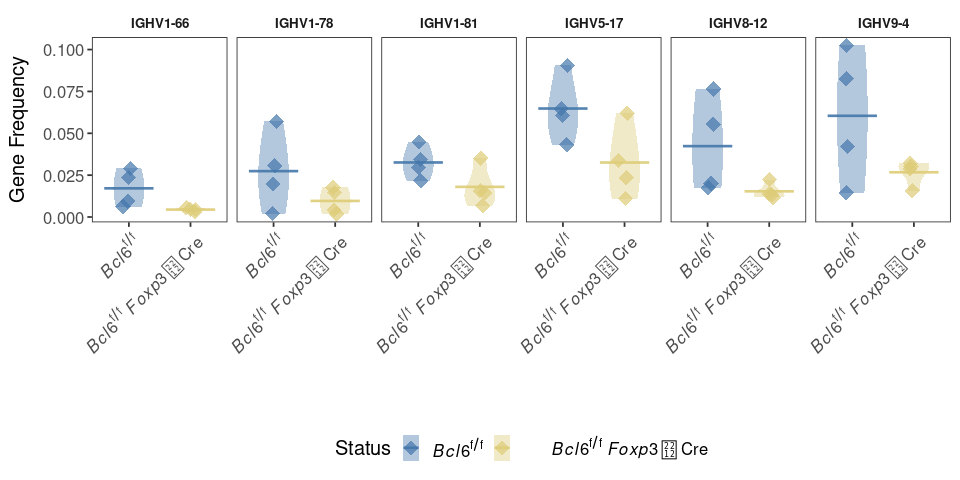

In [149]:
options(repr.plot.width=8, repr.plot.height=4)
p <- vgene_iso_tab %>%
    filter(CREGION == "IgG", grepl("infected", STATUS)) %>% 
    plotGeneSet(tail(pc_gene_up, 6))
plot(p)

In [150]:
plotFigure(p, file.path(PLOT_DIR, "individual_igg_down.pdf"), 8, 4)

png 
  2

In [151]:
plotSvg(p, file.path(PLOT_DIR, "individual_igg_down.svg"), 8, 4)

png 
  2